# Gaussian Process Regression

In [92]:
import numpy as np
import matplotlib.pyplot as plt
#import ipywidgets as widgets  # only needed for isosurfaces, comment out if you don't have it installed
#import ipyvolume as ipv # only needed for isosurfaces, comment out if you don't have it installed
%matplotlib inline
np.seterr(all='ignore')
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic as RQ, DotProduct as DP, Matern

In [62]:
N = 64                           # we discretize our volume using N**3 cells
L = 1.0                           # the box size, sets the fundamental mode

# create a Gaussian random field of size N**3
delta0 = np.random.normal(size=[N,N,N])

kmin = 2.0*np.pi/L # the fundamental mode of the box
kmax = kmin * N/2     # the Nyquist mode of each linear dimension
k1d = np.fft.fftfreq(N,d=1.0/kmin/N)  # get a 1D vector with all values of 'k'
kv = np.meshgrid(k1d,k1d,k1d) # turn this into 3 3D fields giving kx,ky,kz for each point
kmod = np.sqrt(kv[0]**2+kv[1]**2+kv[2]**2)               # get norm k for each point

# now 'kv' is the k vector, and 'kmod' its modulus at every point

alpha = 3.0
norm  = 1.0/(2.0*np.pi)**(-1.5)
# the matter power spectrum is the product of primordial spectrum and T**2
def P(k):
    return k**(-alpha)*norm

In [63]:
# generate a complex random field
fk = np.random.normal(size=(N,N,N)) + 1j * np.random.normal(size=(N,N,N))
fk = fk * np.sqrt(P(kmod))   # impose power spectrum 
fk[0,0,0] = 0.0     # zero f(k=0) to enforce zero mean

# compute (Fast) Fourier Transform of fk
f = np.real(np.fft.ifftn(fk))

# re-normalise (should be done using filtered variance)
f = f / np.std(f.flatten())

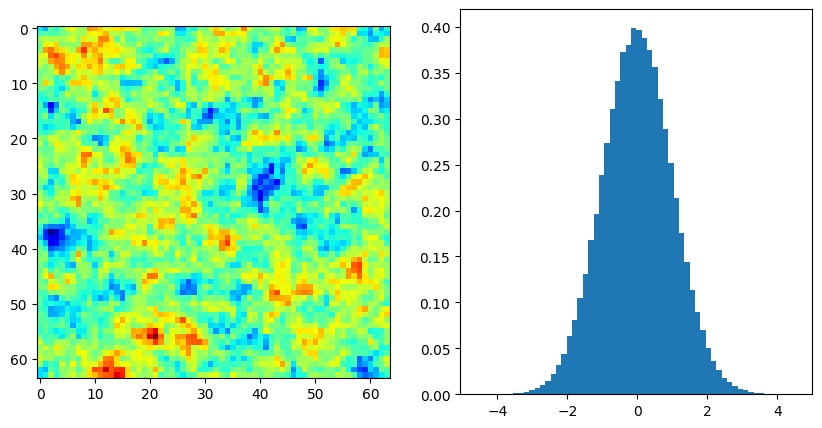

In [64]:
fig, ax = plt.subplots(1,2,figsize=[10,5])
ax[0].imshow(f[...,N//2], cmap='jet')
ax[1].hist(f.flatten(),bins=60,density=True);

In [99]:
# Observations (example random points in a 3D space)
n_obs = 10
X_train = np.random.randint(0, N, size=(n_obs, 3))
y_train = [f[x[0],x[1],x[2]] for x in X_train]

# Points where we want to sample (a grid in a 3D space): array of shape (n_obs, n_features=3)
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
z = np.linspace(0, L, N)
#X_test = np.array([[i, j, k] for i in x for j in y for k in z])
X_test = np.random.randint(0, N, size=(n_obs, 3))
X_test.shape

(10, 3)

In [112]:
# Hyperparameters
length_scale = 1.0       # Given length scale
sigma_f = np.sqrt(norm)  # Scaling factor from the power spectrum normalization

# Define the kernel
# kernel = C(sigma_f**2) * RBF(length_scale=length_scale)
kernel = (2*np.pi)**3 * RBF(length_scale=length_scale)**(alpha)

# Create the GaussianProcessRegressor object
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

# Fit to the observed data
gp.fit(X_train, y_train)

# Make predictions
mu_s, cov_s = gp.predict(X_test, return_cov=True)

# Sample from the posterior distribution
samples = np.random.multivariate_normal(mu_s, cov_s, (N, N, N)).reshape(N, N, N, n_obs)

c:\Users\AltonV\PycharmProjects\CosmicStructures\venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__kernel__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


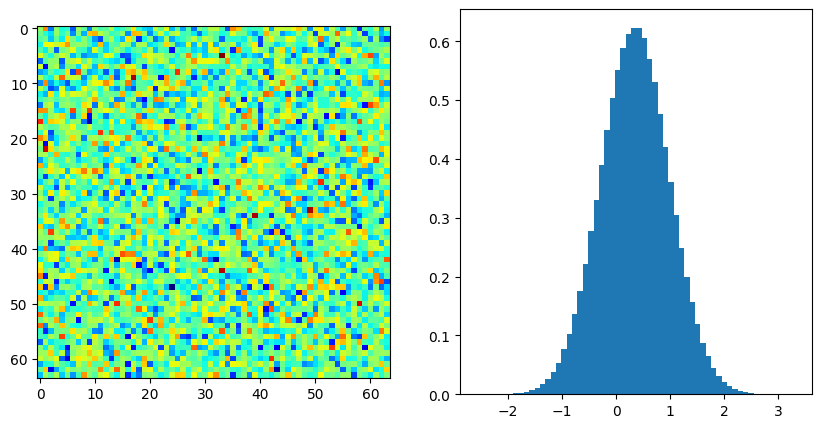

In [110]:

fig, ax = plt.subplots(1, 2, figsize=[10, 5])
ax[0].imshow(samples[:, :, N//2, 0], cmap='jet')
ax[1].hist(samples.flatten(), bins=60, density=True)
plt.show()

In [130]:
# Define the 3D exponential kernel
def exponential_kernel_3d(length_scale=1.0, sigma_f=1.0):
    return C(sigma_f**2) * RBF(length_scale=length_scale)

# Observations (example random points in a 3D space)
n_obs = 10
#X_train = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
X_train = np.random.randint(0, N, size=(n_obs, 3))
print(X_train.shape)
#y_train = np.array([1, 2, 0])
y_train = [f[x[0],x[1],x[2]] for x in sample_points]
print(y_train)

# Points where we want to sample (a grid in a 3D space)
x = np.linspace(0, 128, 10)
y = np.linspace(0, 128, 10)
z = np.linspace(0, 128, 10)
X_test = np.array([[i, j, k] for i in x for j in y for k in z])
# X_test = np.zeros((N,N,N))
print(X_test.shape)

# Hyperparameters
length_scale = 1.0       # given length scale
sigma_f = np.sqrt(1.0/(2.0*np.pi)**(-1.5))  # scaling factor from the power spectrum normalization

# Define the kernel
kernel = exponential_kernel_3d(length_scale=length_scale, sigma_f=sigma_f)

# Create the GaussianProcessRegressor object
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit to the observed data
gp.fit(X_train, y_train)

# Make predictions
mu_s, cov_s = gp.predict(X_test, return_cov=True)

# Sample from the posterior distribution
samples = np.random.multivariate_normal(mu_s, cov_s, 1).reshape(len(x), len(y), len(z))

# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Convert the grid to a format that can be plotted
X_plot, Y_plot, Z_plot = np.meshgrid(x, y, z, indexing='ij')

# Plot the sampled field
scat = ax.scatter(X_plot.flatten(), Y_plot.flatten(), Z_plot.flatten(), c=samples.flatten(), cmap='viridis')
plt.colorbar(scat, ax=ax, shrink=0.5, aspect=5)

# Plot the observations
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='r', marker='o', label='Observations')

ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_zlabel('Z')
ax.legend()
plt.show()



(10, 3)
[0.40592430925373, -0.8733860517902376, -0.3337413421922842, -0.4012277350224318, 0.04952728053219135, 0.6917844208266414, 0.7530529530928541, -0.864754944545431, -0.9450760519689142, -1.3420390379938685]
(128, 128, 128)


ValueError: Found array with dim 3. GaussianProcessRegressor expected <= 2.

In [56]:
def delta_dirac(x, sig):
    val = np.zeros_like(x)
    val[(-(1/(2*sig))<=x) & (x<=(1/(2*sig)))] = 1
    return val

def kronecker_delta(i, j):
    if i == j:
        return 1
    else:
        return 0

def covariance(ki, kj):
     return (2.0 * np.pi)**3 * P(ki)

In [68]:
# Gaussian Process Regression

def covariance_function(x1, x2, length_scale=0.1, sigma_f=1.0):
    """ Squared Exponential kernel (covariance function) """
    sqdist = cdist(x1, x2, 'sqeuclidean')
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

def sample_gp(mean, covariance, n_samples=1):
    """ Sample from a Gaussian process with given mean and covariance """
    return np.random.multivariate_normal(mean, covariance, n_samples)


In [102]:
# Sample points and observations
n_obs = 10
sample_points = np.random.randint(0, N, size=(n_obs, 3))
# sample_values = np.random.normal(size=n_obs) # Use your existing random field 'f'
sample_values = [f[x[0],x[1],x[2]] for x in sample_points]

# Covariance matrices
K = covariance_function(sample_points, sample_points)
K_s = covariance_function(sample_points, sample_points)
K_ss = covariance_function(sample_points, sample_points) + 1e-8 * np.eye(n_obs)

# Mean and covariance for the posterior
K_inv = np.linalg.inv(K + 1e-8 * np.eye(n_obs))
mu_s = K_s.T @ K_inv @ sample_values
cov_s = K_ss - K_s.T @ K_inv @ K_s

# Alternative way to compute the covariance matrix
cov_s2 = np.zeros((n_obs, n_obs))
for i in range(n_obs):
    for j in range(n_obs):
        cov_s2[i,j] = covariance(f[sample_points[i][0], sample_points[i][1], sample_points[i][2]], f[sample_points[j][0], sample_points[j][1], sample_points[j][2]]) / N**3
cov_s2 = np.diagonal(cov_s2) * np.eye(n_obs)


(5, 10)


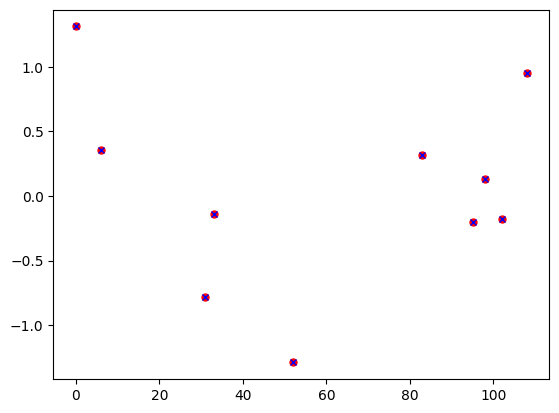

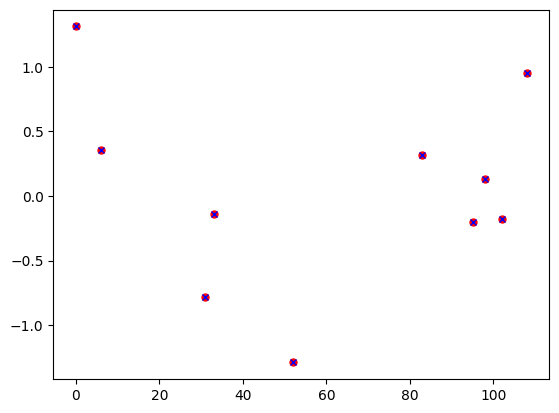

In [105]:
# Sample from the posterior
samples = sample_gp(mu_s, cov_s, n_samples=5)
print(samples.shape)

# Plot one of the samples (for 3D visualization, choose an appropriate tool)
plt.figure()
plt.plot(sample_points[:, 0], sample_values, 'ro', markersize=5)
plt.plot(sample_points[:, 0], samples[0], 'bx', markersize=5)
plt.show()

plt.figure()
plt.plot(sample_points[:, 0], sample_values, 'ro', markersize=5)
plt.plot(sample_points[:, 0], samples[1], 'bx', markersize=5)
plt.show()

# Note: Visualization of the 3D field requires appropriate 3D plotting techniques/tools